<div>
<img src="https://drive.google.com/uc?export=view&id=1vK33e_EqaHgBHcbRV_m38hx6IkG0blK_" width="350"/>
</div> 

#**Artificial Intelligence - MSc**
ET5003 - MACHINE LEARNING APPLICATIONS 

###Instructor: Enrique Naredo
###ET5003_Etivity-1

In [1]:
#@title Current Date
Today = '2021-09-18' #@param {type:"date"}

In [2]:
#@markdown ---
#@markdown ### Enter your details here:
Student_ID = "20156952" #@param {type:"string"}
Student_full_name = "Dáire Campbell" #@param {type:"string"}
#@markdown ---

In [3]:
#@markdown ---
#@markdown ### Enter your details here:
Team = "1" #@param {type:"string"}
Group = "1" #@param {type:"string"}
#@markdown ---

In [4]:
#@title Notebook information
Notebook_type = 'Etivity' #@param ["Example", "Lab", "Practice", "Etivity", "Assignment", "Exam"]
Version = 'Final' #@param ["Draft", "Final"] {type:"raw"}
Submission = True #@param {type:"boolean"}

# Introduction
* Explanation of the problem addressed.  
* Use mathematical notation and images.  
* Add any links to the references.  
* Write your work taking in consideration the reader.  
* Your work must be easy to understand and replicate.  


## MNIST dataset



The MNIST database  is a dataset of handwritten digits that has been and is extensively used in machine learning. There are $10$ classes, each image is $28\times28$ pixels and, therefore, each input is $x_i\in\mathbb{R}^{784}$. 

## Task

You have to extend the code to manage any arbitrary number of classes, in other words you have to implement a general-recipe multinomial logistic classifier and Bayesian multinomial logistic classifier.

You must then select  3 digits at random and perform  the following task. 

1. Your goal is to use Bayesian multinomial logistic regression (as in the road-sign notebook) to solve this classification problem. 

2. You can downsize the training dataset (e.g., 40% training and 60%testing) if the computation of the posterior takes too much time in your computer.

3. Use the posterior uncertainty to detect the instances (digits) in the test set that are hard to classify and remove them from the test-set.

4. Then you need to compute again the accuracy of the general-recipe logistic regression on the remaining (non-difficult) instances and comment on the result.

5. In practice, the task is to use uncertainty estimation to detect the difficult instances in the test-set. This is equivalent to refuse to classify all high-uncertainty instances or, in other words, when we are uncertain we say "I don't know" and we do not return any class. In this way, you will learn how uncertainty can be used to make safer decisions, by detecting the instances that are difficult to classify.


## Libraries

In [5]:
# Suppressing Warnings:
import warnings
warnings.filterwarnings("ignore")

In [6]:
# Install uncommen libraries
# !/mnt/c/ubuntu20.04/masters_ai_ul/e-tivities/masters_in_ul/bin/python -m pip install --upgrade opencv-python
# !/mnt/c/ubuntu20.04/masters_ai_ul/e-tivities/masters_in_ul/bin/python -m pip install --upgrade scikit-image
# !/mnt/c/ubuntu20.04/masters_ai_ul/e-tivities/masters_in_ul/bin/python -m pip install --upgrade arviz
# !/mnt/c/ubuntu20.04/masters_ai_ul/e-tivities/masters_in_ul/bin/python -m pip install --upgrade pymc3

In [7]:
# Import libraries
# Sklearn Logestic Regression Model
from sklearn.linear_model import LogisticRegression

# Sklearn modeules for pre-processing, and validating
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import sklearn.preprocessing
from sklearn.utils import shuffle

# SciPy models for optimisation
import scipy.optimize as optimize
from scipy.special import erf
from scipy.io import loadmat

# Generic Python modules
# Pandas for DataFrames
# Numpy for Numeric functions
# Random
import pandas as pd
import numpy as np
import random

# Visuals
# Seaborn for plots
# Tqdm to visualise the progress
import seaborn as sns
from tqdm import tqdm

# Functions for visual preprocessing
from skimage.io import imread, imshow
from skimage.color import rgb2gray
import matplotlib.image as mpimg

# Matplotlib for plotting
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

# Arviz is used in exploratory analysis of Bayesian models
import arviz as az

# Pymc3 module for statistical modeling
import pymc3 as pm

# Change Jupyter display
from IPython.display import HTML

# Pickle saves/loads pythonic objects as bin
import pickle

# Theano efficiently evaluates mathematical expressions
# involving multi-dimensional arrays
import theano as tt

# Cv2 used for interacting with CV's
import cv2

# use seaborn plotting defaults
import seaborn as sns; sns.set()
plt.rcParams['figure.figsize'] = [12, 8] 

# Improve the Jupyter Notebook display
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [8]:
# Setting a seed:
np.random.seed(123)

# 1. Preprocess Data
Below we will preprocess MNIST dataset.  
The MNIST dataset (Modified National Institute of Standards and Technology) is a large dataset of handwritten digits.  
It compromises of $28\times28$ pixels images of letters, and a label of what digit was written.  
There are 70'000 images (60'000 training and 10'000 testing).  
More information can be found here:  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;https://en.wikipedia.org/wiki/MNIST_database

#### Loading the MNIST dataset

In [9]:
# The code runs quicker locally, but
# I have a Colab version for distribution.
try:
    from google.colab import drive
    drive.mount('/content/drive')
    # Path, copy the path from your Drive
    Path = '/content/drive/MyDrive/Masters_in_AI/et5003/etivity1/'
    print("Running in Colab.")
except Exception as e:
    print("Running locally.")
    Path = "./"

Running locally.


In [10]:
# MNIST Data
train_data = Path + 'mnist_train.csv'
test_data = Path + 'mnist_test.csv'

# train data
df_train = pd.read_csv(train_data)
X_train = df_train.drop("label",axis=1).values
y_train = df_train.label.values
print(X_train.shape)

# test data
df_test = pd.read_csv(test_data)
X_test = df_test.drop("label",axis=1).values
y_test = df_test.label.values
print(X_test.shape)

(60000, 784)
(10000, 784)


In [11]:
# Normalizing the Inputs:
X_train = X_train/255
X_test = X_test/255

# Printing the new input range of values:
minv = np.min(X_train)
maxv = np.max(X_train)
print(minv,maxv)

0.0 1.0


### Description of Data:

In [12]:
# Number of examples
n_train =  len(X_train)
n_test =  len(X_test)

# Shape of an traffic sign image
image_shape = X_train.shape[1]

# unique classes/labels in the training dataset.
alltotal = set(y_train)
n_classes = len(alltotal)

print("Number of Training examples =", n_train)
print("Number of Test examples =", n_test)
print("Image input shape =", image_shape)
print("Number of classes =", n_classes)

Number of Training examples = 60000
Number of Test examples = 10000
Image input shape = 784
Number of classes = 10


### Class Distribution:

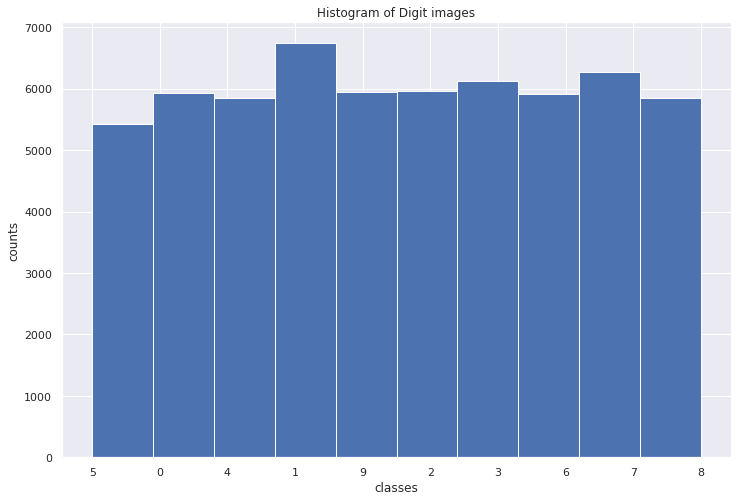

In [13]:
fig, ax = plt.subplots()
ind = np.arange(n_classes)

n, bins, patches = ax.hist([str(i) for i in y_train], n_classes)
ax.set_xlabel('classes')
ax.set_ylabel('counts')
ax.set_title(r'Histogram of Digit images')
plt.show()

###### Summary:  
The classes are generally equally distributed.  
Class 5 is slightly underrepresented, adn class 1 over represented.

## Downsampling
This is training on a disproportionately low subset of the majority class examples.

### Randomly selecting 3 of the 10 Digit Classes

In [14]:
# We select the number of Classes we want:
n_classes = 3

# Empty list to append the random digit classes we select:
classes = []

# We select 3 digits at random and make sure they are unique:
while len(classes) < n_classes:
    
    # Randomly drawing a digit from 0-9:
    num2choose = np.random.randint(0,10)

    # Append the digit if it's not already in our list of classes:
    if num2choose not in classes: 
        classes.append(num2choose)
        
        
# Sorting the Classes smallest to largest    
classes.sort()
# print classes selected
classes

[1, 2, 6]

In [15]:
# The number of instances we'll keep for each of our 3 digits:
inst_class = 5000

inputs = []
labels = []

# Loop to randomly sample the instances for each digit:
for r in classes:
    imgs = X_train[np.where(y_train==r)[0],:]
    inputs.append(imgs[np.random.permutation(imgs.shape[0]),:][0:inst_class,:])
    
    # Getting the minimum of number of images and number of instances
    # This stops errors if number of instances > number of images
    labels.append(np.ones(min(len(imgs), inst_class))*r)
    
# Shaping inputs and labels in the right format    
X_train = np.vstack(inputs).astype(np.float64)
y_train = np.hstack(labels)

New Classes Distribution

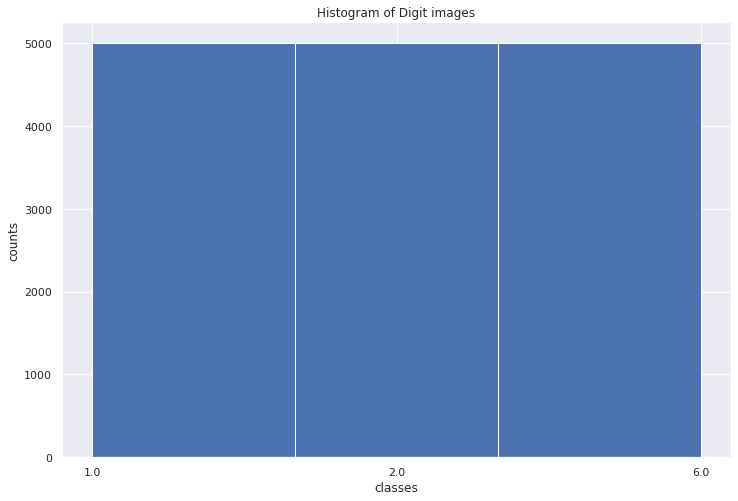

In [16]:
fig, ax = plt.subplots()
ind = np.arange(n_classes)

n, bins, patches = ax.hist([str(i) for i in y_train], len(set(y_train)))
ax.set_xlabel('classes')
ax.set_ylabel('counts')
ax.set_title(r'Histogram of Digit images')
plt.show()

In [17]:
# plot digits
def plot_digits(instances, images_per_row=5, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image,  cmap='gist_yarg', **options)
    plt.axis("off")

In [18]:
# A function to return random indices for a class

def random_indices_of_labels(y_train, ind = 2):
    """
    Function to get generate random indices corresponding
        to the labels.
        
    ::param y_train: (numpy array)
    ::param ind: (int) Number of indices per class
    ::return: (list[int])
    """
    r_indices = []
    for i in set(y_train):
        r_indices += np.random.choice(
            [y for y, x in enumerate(y_train) if x == i], ind)\
        .tolist()
    return r_indices

Text(0.5, 1.0, 'Original')

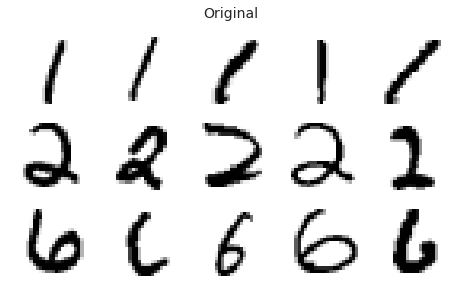

In [19]:
# Show a few instances from each Digit:
plt.figure(figsize=(8,8))

# Selecting a few label indices from each of the 3 classes to show:
label_indices = random_indices_of_labels(y_train, 5)

# Plotting 'original' image
plot_digits(X_train[label_indices,:],images_per_row=5)
plt.title("Original", fontsize=14)

###  Splitting the Training data into both Training and Validation Sets:

- Although this is the Training set, we can still set aside some samples (for instance 20%) of the 5000 instances we have for Model Validation purposes.


- With that Validation Set, we can then select the amount of Uncertainty we are happy with from our Model to use out of sample on other unseen data.


- We can then test out how well our decision performs on the Test Set that we put aside earlier.

In [20]:
len(X_train), len(y_train)

(15000, 15000)

In [21]:
### Split tha dataset in training and validation sets
# choose the fraction of your validation data from the training set
w = 0.20
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=w, random_state=0)
 
# Shuffling the training instaces around to randomize the order of inputs to the model:
X_train, y_train = shuffle(X_train, y_train)

In [22]:
# print shape of your validation and training set

print("Shape of validation dataset: ", X_train.shape)
print("Shape of test dataset: ", X_val.shape)


Shape of validation dataset:  (12000, 784)
Shape of test dataset:  (3000, 784)


### Encoding the Class labels for the Probabilistic ML Model:

This is an example:

- **[1,0,0]** for first digit
- **[0,1,0]** for second digit
- **[0,0,1]** for third digit

In [23]:
y_val.reshape(-1,1)

array([[1.],
       [6.],
       [6.],
       ...,
       [6.],
       [2.],
       [1.]])

In [24]:
y_train_bin = sklearn.preprocessing.LabelBinarizer().fit_transform(y_train.reshape(-1,1))
y_val_bin = sklearn.preprocessing.LabelBinarizer().fit_transform(y_val.reshape(-1,1))

print("Example label: ", y_train_bin[0])

Example label:  [0 0 1]


### General-Recipe ML
SKlearn model:  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

This is a quick Logestic Regression model to help us have a better idea of the data classification.

In [145]:
# model
# Train the Sklearn Logistic Regression model
model_log = LogisticRegression(
    random_state=0, # Used to shuffle the data
    max_iter=2000, # Maximum number of iterations taken for the solvers to converge.
    C=100, # Inverse of regularization strength
    solver='lbfgs', # Algorithm to use in the optimization problem
        # https://en.wikipedia.org/wiki/Broyden%E2%80%93Fletcher%E2%80%93Goldfarb%E2%80%93Shanno_algorithm
    multi_class='multinomial'
)\
.fit(X_train, y_train)

# Use above model to classify on the validation dataset
# Classification:
y_pred_log_val = model_log.predict(X_val) # Prediction
y_pred_logi_prob_val = model_log.predict_proba(X_val) # Probability score

# Maybe taking the maximum probability 
# in any of the classes for each observation
maximum_prob = y_pred_logi_prob_val.max(axis = 1)

# Computing the Accuracy:
print("Accuracy of model (for validation dataset): ", accuracy_score(y_pred_log_val, y_val))

Accuracy of model (for validation dataset):  0.974


### Below I try to better understand the results of the General-Recipe ML predictions

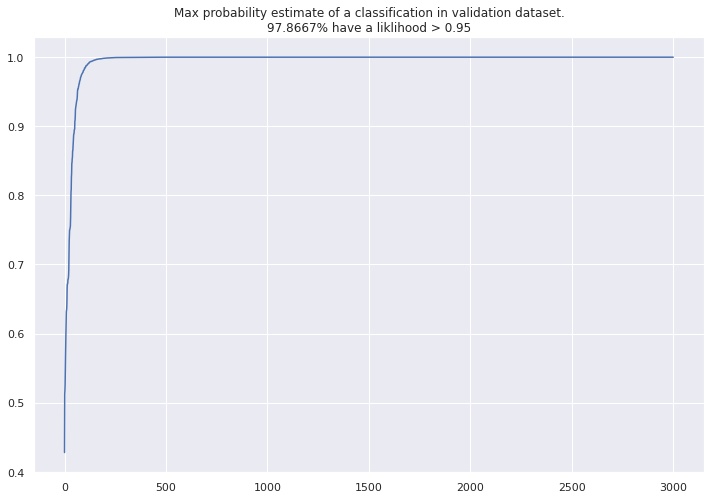

In [146]:
# The below plot visuals the probability of the predictions
# How many predictions have a threshold greater than 0.95      

thresh = 0.95
perc = round(
    sum(maximum_prob > thresh)*100/len(maximum_prob), 4)

ax = plt.axes()
sns.lineplot(range(len(maximum_prob)), np.sort(maximum_prob), ax = ax)

ax.set_title(f'Max probability estimate of a classification in validation dataset.\n{perc}% have a liklihood > {thresh}')
plt.show()

The above graph shows that the vast majority of predictions have greater than 0.95 probability for predicting a classification.

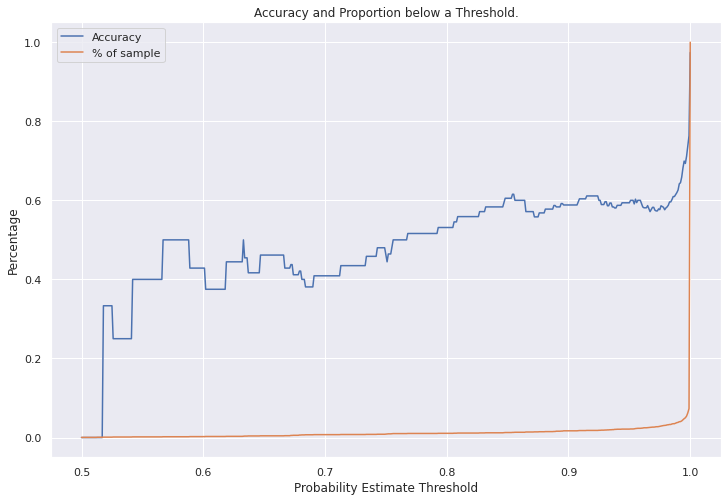

In [147]:
# Here we check the accuracy of prediction per probability thresholds.

# Step in probability
step = 0.001

# Range between Probability estimates of 0.5 and 1.
confidence_ranges = np.arange(0.5, 1+step, step)

accuracy_l = []
count_perc_l = []

for con_r in confidence_ranges:
    # Filter to apply to data
    # For each step we only care about the probability below this probability
    filt = maximum_prob <= float(con_r)
    
    # Store the accuracy and counts
    accuracy_l +=[accuracy_score(y_pred_log_val[filt], y_val[filt])]
    count_perc_l +=[len(y_pred_log_val[filt])/len(y_pred_log_val)]


plt.plot(confidence_ranges, accuracy_l, label='Accuracy')
plt.plot(confidence_ranges, count_perc_l, label='% of sample')
plt.legend(loc='best')
plt.title(f"Accuracy and Proportion below a Threshold.")
plt.xlabel("Probability Estimate Threshold")
plt.ylabel("Percentage")
plt.show()

The above graph shows that the model is uncertian (accuracy of ~ 0.6) until a threshold of ~0.99.  
This is because the vast majoity of the data has a prediction of greater than 0.99.  
Hence anything with a confidence less than 0.99 should be considered Unknown.  

If a classification has a prediction < 0.975, it may be an incorrect classification, or Unknown.

In [156]:
# Apply General-Recipe Model on test-data

# First filter test data onto only teh 3 classes created above
filt = np.isin(y_test, classes)

X_test_ = X_test[filt]
y_test_ = y_test[filt]

# Classification:
y_pred_log = model_log.predict(X_test_)
y_pred_logi_prob = model_log.predict_proba(X_test_)

# Maybe taking the maximum probability 
# in any of the classes for each observation
maximum_prob = y_pred_logi_prob.max(axis = 1)

# Computing the Accuracy:
test_accuracy = accuracy_score(y_pred_log, y_test_)
print("Accuracy of model (for test dataset): ", test_accuracy)

Accuracy of model (for test dataset):  0.9744


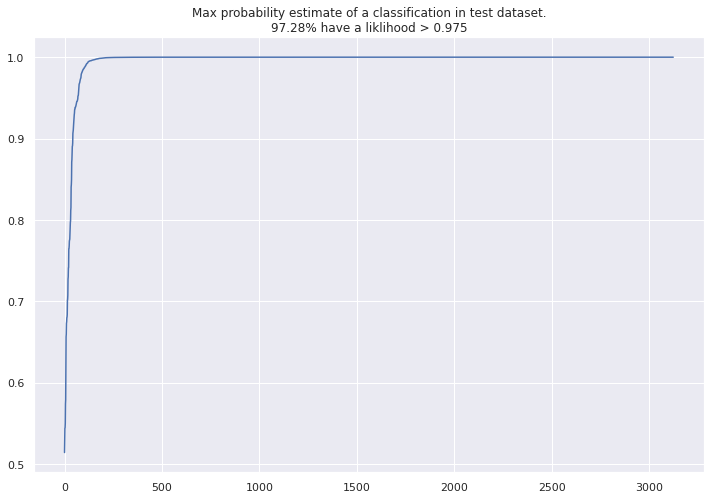

In [47]:
# The below plot visuals the probability of the predictions
# How many predictions have a threshold greater than 0.95      

thresh = 0.975
perc = round(
    sum(maximum_prob > thresh)*100/len(maximum_prob), 4)

ax = plt.axes()
sns.lineplot(range(len(maximum_prob)), np.sort(maximum_prob), ax = ax)

ax.set_title(f'Max probability estimate of a classification in test dataset.\n{perc}% have a liklihood > {thresh}')
plt.show()

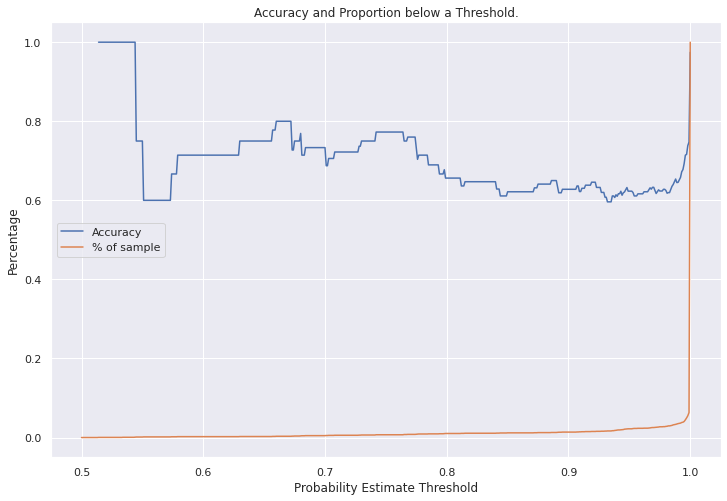

In [52]:
# Here we check the accuracy of prediction per probability thresholds.

# Step in probability
step = 0.001

# Range between Probability estimates of 0.5 and 1.
confidence_ranges = np.arange(0.5, 1+step, step)

accuracy_l = []
count_perc_l = []

for con_r in confidence_ranges:
    # Filter to apply to data
    # For each step we only care about the probability below this probability
    filt = maximum_prob <= float(con_r)
    
    # Store the accuracy and counts
    accuracy_l +=[accuracy_score(y_pred_log[filt], y_test_[filt])]
    count_perc_l +=[len(y_pred_log[filt])/len(y_pred_log)]


plt.plot(confidence_ranges, accuracy_l, label='Accuracy')
plt.plot(confidence_ranges, count_perc_l, label='% of sample')
plt.legend(loc='best')
plt.title(f"Accuracy and Proportion below a Threshold.")
plt.xlabel("Probability Estimate Threshold")
plt.ylabel("Percentage")
plt.show()

###### Comment:
Here we see the accuracy of the test set.  

### Probabilistic Multinomial Logistic Regression:

In [57]:
# Number of values
nf = X_train.shape[1]

# number of classes
nc = len(classes)

# floatX = float32 (actually flaot 64)
floatX = tt.config.floatX

# Initial weightings
init_b = np.random.randn(nf, nc-1).astype(floatX)
init_a = np.random.randn(nc-1).astype(floatX)

The Multinomial Logistic Regression has some parameters:

- $\alpha$, which is the intercept term:

- $\beta$, which is a vector of coefficients which give a weighting to the importance of each input feature:


In [62]:
with pm.Model() as multi_logistic:
    # Prior
    β = pm.Normal('beta', 0, sigma=100, shape=(nf, nc-1), testval=init_b)
    α = pm.Normal('alpha', 0, sigma=100, shape=(nc-1,), testval=init_a)
    
    # we need to consider nc-1 features because the model is not identifiable
    # the softmax turns a vector into a probability that sums up to one
    # therefore we add zeros to go back to dimension nc
    # so that softmax returns a vector of dimension nc
    β1  = tt.tensor.concatenate([np.zeros((nf,1)),β ],axis=1)
    α1  = tt.tensor.concatenate([[0],α ],)
    
    # Likelihood
    mu = pm.math.matrix_dot(X_train,β1) + α1
    # It doesn't work if the problem is binary
    p = tt.tensor.nnet.nnet.softmax(mu)
    observed = pm.Multinomial('likelihood', p=p, n=1, observed=y_train_bin)

In [74]:
# Fit the model
with multi_logistic:
    approx = pm.fit(15000, method='advi') # takes longer
    # approx = pm.fit(3000, method='advi')

Finished [100%]: Average Loss = 7,023


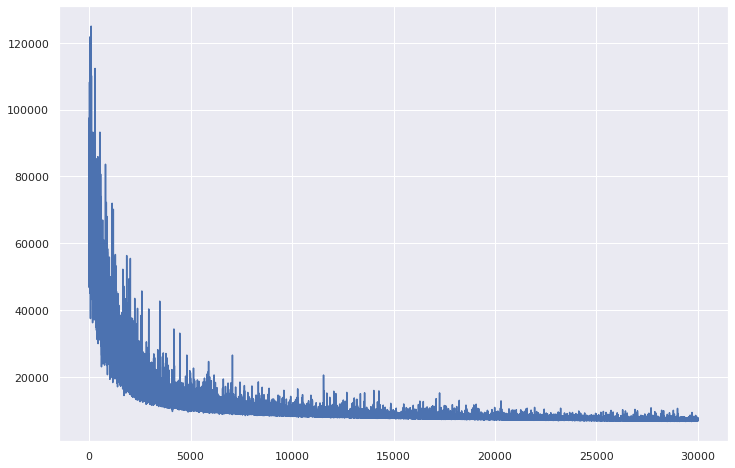

In [76]:
plt.plot(approx.hist)

In [77]:
dd = 300
posterior = approx.sample(draws=dd)

test image #287
posterior sample #295
true class= 6.0
classes: [1, 2, 6]
estimated prob= [0. 0. 1.]


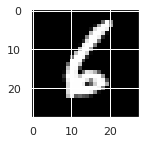

In [87]:
## The softmax function transforms each element of a collection by computing the exponential
#  of each element divided by the sum of the exponentials of all the elements.
from scipy.special import softmax

#select an image in the test set

i = random.randint(0, dd)

#select a sample in the posterior
s = random.randint(0, dd)


beta  = np.hstack([np.zeros((nf,1)),  posterior['beta'][s,:] ])
alpha = np.hstack([[0],  posterior['alpha'][s,:] ])
image = X_val[i,:].reshape(28,28)
plt.figure(figsize=(2,2))
plt.imshow(image,cmap="Greys_r")
np.set_printoptions(suppress=True)

print("test image #" + str(i))
print("posterior sample #" + str(s))
print("true class=", y_val[i])
print("classes: " + str(classes))
print("estimated prob=",softmax((np.array([X_val[i,:].dot(beta) + alpha])))[0,:])

The below can take a long time to run.

In [88]:
# Bayesian prediction
# return the class that has the highest posterior probability
y_pred_Bayesian=[]

for i in tqdm(range(X_val.shape[0])):
    val=np.zeros((1,len(classes)))
    
    for s in range(posterior['beta'].shape[0]):
        beta = np.hstack([np.zeros((nf,1)),  posterior['beta'][s,:] ])
        alpha = np.hstack([[0],  posterior['alpha'][s,:] ])     
        val = val + softmax((np.array([X_val[i,:].dot(beta) + alpha])))
    
    mean_probability = val/posterior['beta'].shape[0]
    y_pred_Bayesian.append( np.argmax(mean_probability))


100%|██████████| 3000/3000 [02:11<00:00, 22.79it/s]


In [89]:
# using validation: y_val
print("Accuracy=", accuracy_score(np.array(classes)[y_pred_Bayesian], y_val))

Accuracy= 0.9816666666666667


## Selecting different instances

In [191]:
y_predB=[]

for i in tqdm(range(X_val.shape[0])):
    #print(i)
    val=[]

    for s in range(posterior['beta'].shape[0]):
        beta = np.hstack([np.zeros((nf,1)),  posterior['beta'][s,:] ])
        alpha = np.hstack([[0],  posterior['alpha'][s,:] ])
        val.append(softmax((np.array([X_val[i,:].dot(beta) + alpha])))[0,:])

    #mean probability
    valmean = np.mean(val,axis=0)
    #class with maximum mean probability
    classmax = np.argmax(valmean)
    #ranks
    ranks = np.array(val.copy())
    ranks   = ranks  *0 #init
    colmax = np.argmax(np.array(val),axis=1)
    ranks[np.arange(0,len(colmax)),colmax]=1
     
    y_predB.append( [classmax, valmean[classmax], np.std(ranks,axis=0)[classmax]])

    
y_predB= np.array(y_predB)

100%|██████████| 3000/3000 [02:10<00:00, 22.93it/s]


array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0

In [117]:
# Bayesian prediction
# return the class that has the highest posterior probability
y_pred_Bayesian=[]

for i in tqdm(range(X_val.shape[0])):
    val=np.zeros((1,len(classes)))
    
    for s in range(posterior['beta'].shape[0]):
        beta = np.hstack([np.zeros((nf,1)),  posterior['beta'][s,:] ])
        alpha = np.hstack([[0],  posterior['alpha'][s,:] ])     
        val = val + softmax((np.array([X_val[i,:].dot(beta) + alpha])))
    
    mean_probability = val/posterior['beta'].shape[0]
    y_pred_Bayesian.append( np.argmax(mean_probability))


100%|██████████| 3000/3000 [02:07<00:00, 23.47it/s]


In [150]:
## Difficult & easy instances

i = 200

easy = np.argsort(y_predB[:,2])
print("Accuracy in easy instances =", accuracy_score(y_pred_log_val[easy[0:i]], y_val[easy[0:i]]))

difficult = np.argsort(-y_predB[:,2])
print("Accuracy in difficult instances =", accuracy_score(y_pred_log_val[difficult[0:i]], y_val[difficult[0:i]]))

Accuracy in easy instances = 0.99
Accuracy in difficult instances = 0.74


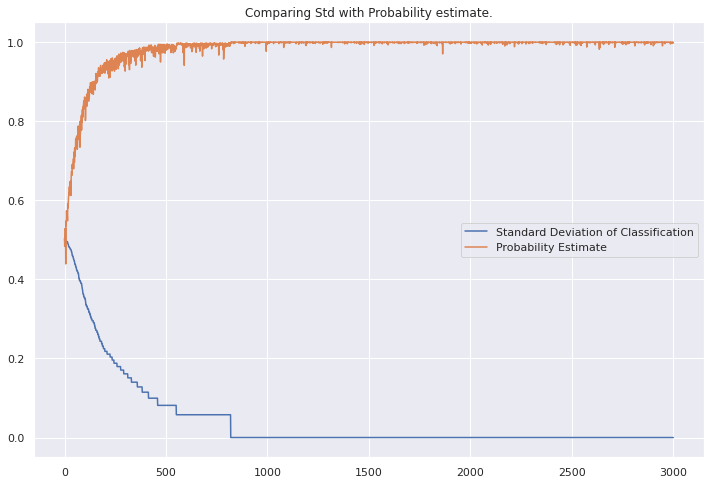

In [138]:
plt.plot(range(len(y_predB)), y_predB[difficult][:,2], label='Standard Deviation of Classification')
plt.plot(range(len(y_predB)), y_predB[difficult][:,1], label='Probability Estimate')
plt.legend(loc='best')
plt.title(f"Comparing Standard Deviation with Probability Estimate.")
plt.show()

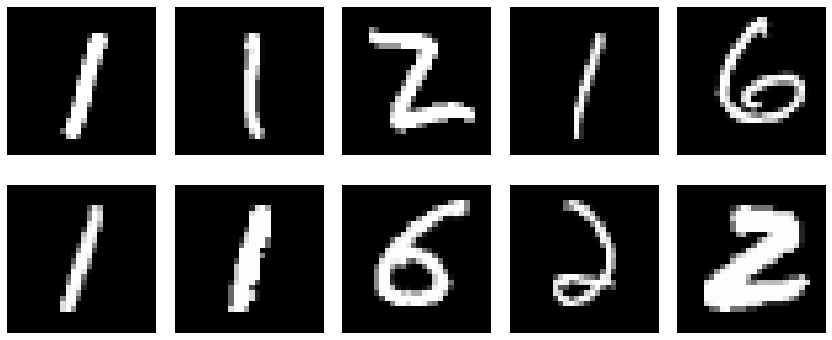

In [119]:
# show 10 random 'easy' images
fig, axs = plt.subplots(2,5, figsize=(15, 6))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()

for i in range(10):
    index = easy[i]
    image = X_val[index,:].reshape(28,28)
    axs[i].axis('off')
    axs[i].imshow(image,cmap="Greys_r")
    

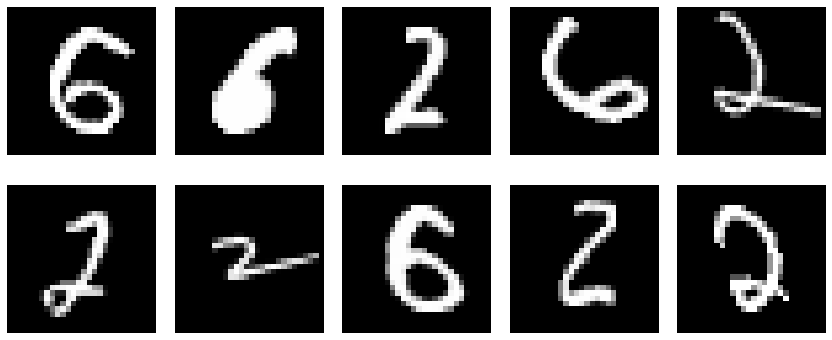

In [120]:

# show 10 random 'difficult' images
fig, axs = plt.subplots(2,5, figsize=(15, 6))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()
for i in range(10):
    index = difficult[i]
    image = X_val[index,:].reshape(28,28)
    axs[i].axis('off')
    axs[i].imshow(image,cmap="Greys_r")
    

## Implementing on test dataset
Detect the instances (digits) in the test set that are hard to classify.

In [163]:
y_predB=[]

for i in tqdm(range(X_test_.shape[0])):
    #print(i)
    val=[]

    for s in range(posterior['beta'].shape[0]):
        beta = np.hstack([np.zeros((nf,1)),  posterior['beta'][s,:] ])
        alpha = np.hstack([[0],  posterior['alpha'][s,:] ])
        val.append(softmax((np.array([X_test_[i,:].dot(beta) + alpha])))[0,:])

    #mean probability
    valmean = np.mean(val,axis=0)
    #class with maximum mean probability
    classmax = np.argmax(valmean)
    #ranks
    ranks = np.array(val.copy())
    ranks   = ranks  *0 #init
    colmax = np.argmax(np.array(val),axis=1)
    ranks[np.arange(0,len(colmax)),colmax]=1
     
    y_predB.append( [classmax, valmean[classmax], np.std(ranks,axis=0)[classmax]])

    
y_predB= np.array(y_predB)

100%|██████████| 3125/3125 [02:20<00:00, 22.21it/s]


In [169]:
## Difficult & easy instances

i = 200

easy = np.argsort(y_predB[:,2])
print("Accuracy in easy instances =", accuracy_score(y_pred_log[easy[0:i]], y_test_[easy[0:i]]))

difficult = np.argsort(-y_predB[:,2])
print("Accuracy in difficult instances =", accuracy_score(y_pred_log[difficult[0:i]], y_test_[difficult[0:i]]))

Accuracy in easy instances = 1.0
Accuracy in difficult instances = 0.74


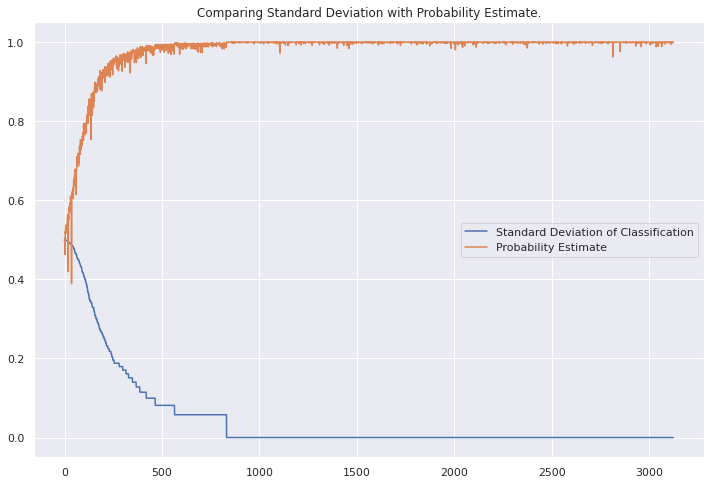

In [170]:
plt.plot(range(len(y_predB)), y_predB[difficult][:,2], label='Standard Deviation of Classification')
plt.plot(range(len(y_predB)), y_predB[difficult][:,1], label='Probability Estimate')
plt.legend(loc='best')
plt.title(f"Comparing Standard Deviation with Probability Estimate.")
plt.show()

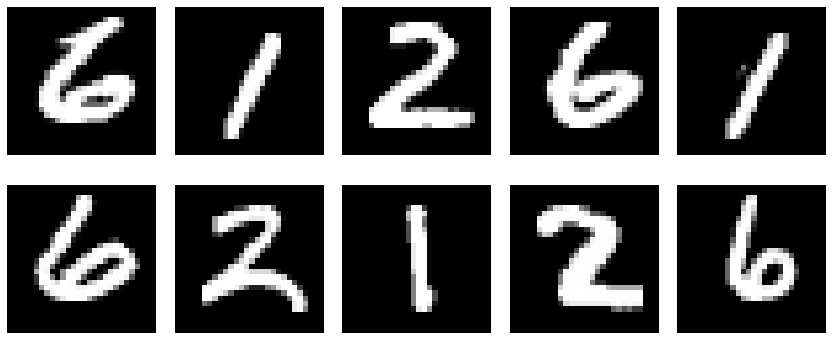

In [173]:
# show 10 random 'easy' images
fig, axs = plt.subplots(2,5, figsize=(15, 6))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()

for i in range(10):
    index = easy[i]
    image = X_test_[index,:].reshape(28,28)
    axs[i].axis('off')
    axs[i].imshow(image,cmap="Greys_r")
    

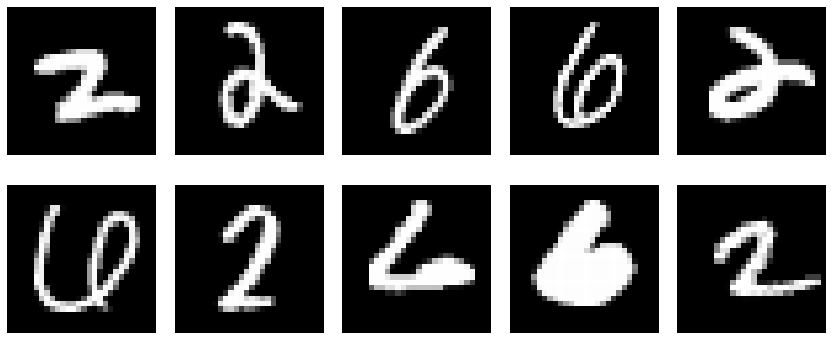

In [174]:
# show 10 random 'difficult' images
fig, axs = plt.subplots(2,5, figsize=(15, 6))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()
for i in range(10):
    index = difficult[i]
    image = X_test_[index,:].reshape(28,28)
    axs[i].axis('off')
    axs[i].imshow(image,cmap="Greys_r")
    

Remove the test values that are hard to classify.  
Compute again the accuracy of the general-recipe logistic regression on the remaining (non-difficult) instances and comment on the result.

In [182]:
# Keep all values where the standerd deviation  is 0.  
# This will remove all predictions which didnt consintly get predicted to be a single class in y_predB.
# This may be too restrictive, but will keep all non-difficult instances.

X_test_easy = X_test_[y_predB[:,2] == 0]
y_test_easy = y_test_[y_predB[:,2] == 0]

In [192]:
# Apply General-Recipe Model on test-data on only the easy data

# Classification:
y_pred_log = model_log.predict(X_test_easy)
y_pred_logi_prob = model_log.predict_proba(X_test_easy)

# Maybe taking the maximum probability 
# in any of the classes for each observation
maximum_prob = y_pred_logi_prob.max(axis = 1)

print("Initial size of dataset: ", len(X_test_))
print("Number of non-difficult instances: ", len(X_test_easy))
print(f"This accounts for {round((len(X_test_easy)*100)/len(X_test_),2)}% of instances.")
print(f"{round(100 - (len(X_test_easy)*100)/len(X_test_),2)}% of instances are removed.")
print("")

# Computing the Accuracy:
print("Accuracy of model (for test dataset) using all instances : ", test_accuracy)
print("Accuracy of model (for test dataset) using non-difficult instances : ", 
     accuracy_score(y_pred_log, y_test_easy))

Initial size of dataset:  3125
Number of non-difficult instances:  2293
This accounts for 73.38% of instances.
26.62% of instances are removed.

Accuracy of model (for test dataset) using all instances :  0.9744
Accuracy of model (for test dataset) using non-difficult instances :  0.9956389010030527


##### Comment:
Removing the non-easy instances of the test dataset, leaving remaining (non-difficult) instances, improved the accuracy.  
This is to be expected, as we have removed the instances which are potentially difficult to to predict.  
We classify "difficult to predict" as instances which we failed to predict a single class with in pymc3 models.

## Summary

In this assignment we have removed non-difficult values from the test dataset.  
This improved the accuracy from 0.974 to 0.996.  
This is as we used the posterior uncertainty to detect the instances (digits) in the test set that are hard to classify and removed them from the test-set.  

However, it should be noted that 26.62% of the test instances were removed as they were classified as difficult to classify.  
This could be as I am classifying difficult values as any value which didn't get uniformly classified to a single class, and hence has a standard deviation > 0 for the classification for different instances.  

Therefore we need to note the what proportion of the instances are labeled hard to classify, as if non-difficult instances only account for <20% of the dataset, and the rest of the dataset is hard to classify. This would imply the data is difficult to classify in its current shape.